# Analysis and visualization of spatial transcriptomics data

This tutorial shows how to work with multiple Visium datasets and perform integration of scRNA-seq dataset with **Scanpy**. It follows the [previous tutorial](https://github.com/theislab/scanpy-tutorials/blob/master/analysis-visualization-spatial.ipynb) on analysis and visualization of spatial transcriptomics data.

We will use **Scanorama** [paper](https://www.nature.com/articles/s41587-019-0113-3) - [code](https://github.com/brianhie/scanorama) to perform integration and label transfer. It has a convenient interface with scanpy and anndata. 

To install the required libraries, type the following:

```
pip install scanpy
pip install scanorama
```

### Loading libraries

In [11]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import scanorama

%load_ext autoreload
%autoreload 2

mpl.use('module://ipykernel.pylab.backend_inline')
plt.rcParams['figure.figsize']=(5,5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Reading the data

We will use two **Visium** spatial transcriptomics dataset of the mouse brain (Sagittal), which are publicly available from the 10x genomics website: [link](https://support.10xgenomics.com/spatial-gene-expression/datasets/).

The function `datasets.visium_sge()` downloads the dataset from 10x genomics and returns an AnnData object that contains counts, images and spatial coordinates. We will calculate standards QC metrics with `pp.calculate_qc_metrics` and visualize them.

When using your own Visium data, use Scanpy's [`read_visium()`](https://icb-scanpy.readthedocs-hosted.com/en/latest/api/scanpy.read_visium.html) function to import it.


In [2]:
adata_spatial_anterior = sc.datasets.visium_sge(sample_id = 'V1_Mouse_Brain_Sagittal_Posterior')
adata_spatial_posterior = sc.datasets.visium_sge(sample_id = 'V1_Mouse_Brain_Sagittal_Posterior')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata_spatial_anterior.var_names_make_unique()
adata_spatial_posterior.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_spatial_anterior, inplace=True)
sc.pp.calculate_qc_metrics(adata_spatial_posterior, inplace=True)

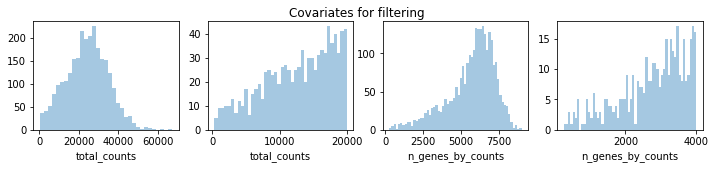

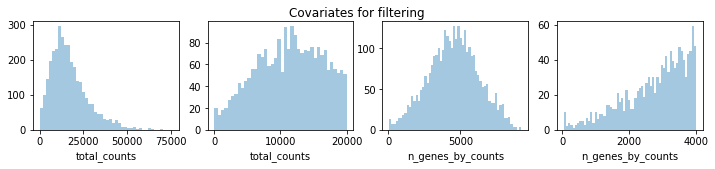

In [4]:
fig, axs = plt.subplots(1,4, figsize=(12,2))
fig.suptitle('Covariates for filtering')
sb.distplot(adata_spatial_anterior.obs['total_counts'], kde=False, ax = axs[0])
sb.distplot(adata_spatial_anterior.obs['total_counts'][adata_spatial_anterior.obs['total_counts']<20000], kde=False, bins=40, ax = axs[1])
sb.distplot(adata_spatial_anterior.obs['n_genes_by_counts'], kde=False, bins=60, ax = axs[2])
sb.distplot(adata_spatial_anterior.obs['n_genes_by_counts'][adata_spatial_anterior.obs['n_genes_by_counts']<4000], kde=False, bins=60, ax = axs[3])
fig, axs = plt.subplots(1,4, figsize=(12,2))
fig.suptitle('Covariates for filtering')
sb.distplot(adata_spatial_posterior.obs['total_counts'], kde=False, ax = axs[0])
sb.distplot(adata_spatial_posterior.obs['total_counts'][adata_spatial_posterior.obs['total_counts']<20000], kde=False, bins=40, ax = axs[1])
sb.distplot(adata_spatial_posterior.obs['n_genes_by_counts'], kde=False, bins=60, ax = axs[2])
sb.distplot(adata_spatial_posterior.obs['n_genes_by_counts'][adata_spatial_posterior.obs['n_genes_by_counts']<4000], kde=False, bins=60, ax = axs[3])

We proceed to normalize Visium counts data with the built-in `normalize_total` method from Scanpy, and detect highly-variable genes (for later). As discussed previously, note that there are more sensible alternatives for normalization (see discussion in [sc-tutorial paper](https://www.embopress.org/doi/full/10.15252/msb.20188746) and more recent alternatives such as [SCTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1) or [GLM-PCA](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6)).

In [5]:
sc.pp.normalize_total(adata_spatial_anterior, inplace = True)
sc.pp.log1p(adata_spatial_anterior)
sc.pp.highly_variable_genes(adata_spatial_anterior, flavor='seurat', n_top_genes=2000, inplace=True)

sc.pp.normalize_total(adata_spatial_posterior, inplace = True)
sc.pp.log1p(adata_spatial_posterior)
sc.pp.highly_variable_genes(adata_spatial_posterior, flavor='seurat', n_top_genes=2000, inplace=True)

### Data integration

We are now ready to perform integration of the two dataset. As mentioned before, we will be using Scanorama for that. Scanorama returns two lists, one for the integrated embeddings and one for the corrected counts, for each dataset.

In [6]:
adatas = [adata_spatial_anterior, adata_spatial_posterior]
# Integration.
integrated, corrected = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 31053 genes among all datasets
[[0.         0.48165822]
 [0.         0.        ]]
Processing datasets (0, 1)


We will concatenate the two datasets and save the integrated embeddings in `adata_spatial.obsm['X_emb']`. Furthermore we will compute UMAP to visualize the results and qualitatively assess the data integration task.

In [7]:
adata_spatial = adata_spatial_anterior.concatenate(adata_spatial_posterior, 
                                           batch_key = "library_id", 
                                           batch_categories=[k for d in [adata_spatial_anterior.uns['spatial'],adata_spatial_posterior.uns['spatial']] for k,v in d.items()], 
                                           merge_uns="if_clean")

In [8]:
embedding = np.concatenate(integrated, axis = 0)
adata_spatial.obsm['X_emb'] = embedding
sc.pp.neighbors(adata_spatial, use_rep='X_emb')
sc.tl.umap(adata_spatial)
sc.tl.louvain(adata_spatial, key_added='clusters')

/Users/giovanni.palla/Projects/scanpy/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/giovanni.palla/Projects/scanpy/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/Users/giovanni.palla/Projects/scanpy/scanpy/tools/_umap.py:144: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),
/Users/giovanni.palla/Projects/scanpy/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'c

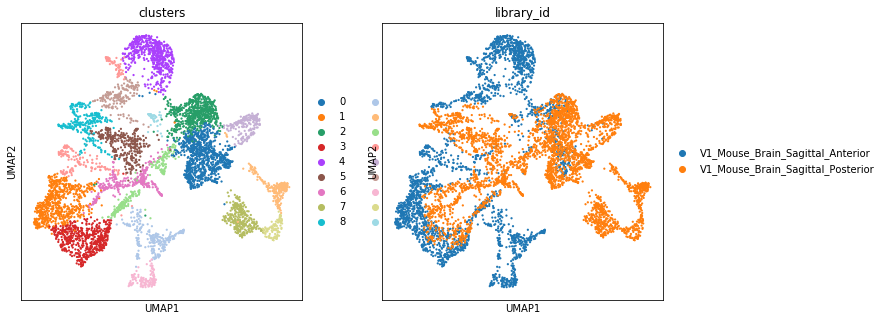

In [34]:
sc.pl.umap(adata_spatial, color = ["clusters","library_id"], palette=sc.pl.palettes.default_20)

We can also visualize the clustering result in spatial coordinates. For that, we first need to save the cluster colors in a dictionary. We can then plot the Visium tissue fo the Anterior and Posterior Sagittal view, alongside each other.

In [37]:
clusters_colors = dict(zip([str(i) for i in range(18)], adata_spatial.uns['clusters_colors']))

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


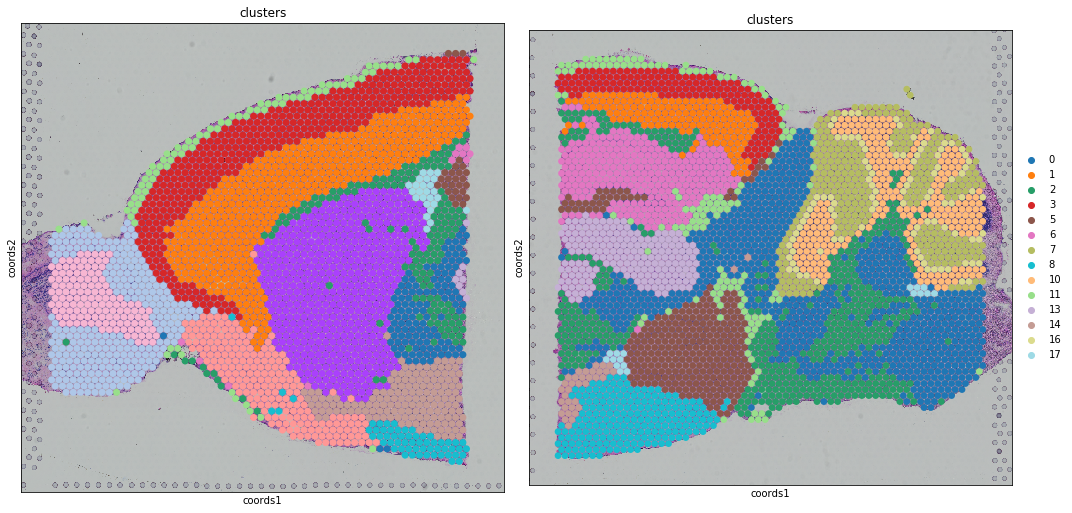

In [44]:
ad_anterior = adata_spatial[adata_spatial.obs.library_id == "V1_Mouse_Brain_Sagittal_Anterior", :]
ad_posterior = adata_spatial[adata_spatial.obs.library_id == "V1_Mouse_Brain_Sagittal_Posterior", :]

fig, axs = plt.subplots(1,2, figsize=(15,10))
sc.pl.spatial(
    ad_anterior, 
    img_key = "hires", 
    library_id ="V1_Mouse_Brain_Sagittal_Anterior", 
    color="clusters", 
    size=1.5,
    palette = [v for k,v in  clusters_colors.items() if k in ad_anterior.obs.clusters.unique().tolist()],
    legend_loc=None,
    show = False,
    ax = axs[0])

sc.pl.spatial(
    ad_posterior, 
    img_key = "hires", 
    library_id ="V1_Mouse_Brain_Sagittal_Posterior", 
    color="clusters", 
    size=1.5,
    palette = [v for k,v in  clusters_colors.items() if k in ad_posterior.obs.clusters.unique().tolist()],
    show = False,
    ax = axs[1])

plt.tight_layout()

From the clusters, we can clearly see the stratification of the cortical layer in both of the tissues (see the [Allen brain atlas](https://mouse.brain-map.org/experiment/thumbnails/100042147?image_type=atlas) for reference). Furthermore, it seems that the dataset integration worked well, since there is a clear continuity between clusters in the two tissues. 

### Data integration and label transfer from scRNA-seq dataset

Another type of data integration that can be performed is between a scRNA-seq dataset and a spatial transcriptomics dataset. Such task is particularly useful because it allow us to transfer cell types, identified from the scRNA-seq dataset, to the Visium dataset. 

For this task, we will be using a dataset from [Tasic et al.](https://www.nature.com/articles/s41586-018-0654-5), where the mouse cortex was profiled with smart-seq technology.

The dataset can be downloaded from **[GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115746)** [count](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE115nnn/GSE115746/suppl/GSE115746_cells_exon_counts.csv.gz) - [metadata](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE115nnn/GSE115746/suppl/GSE115746_complete_metadata_28706-cells.csv.gz).
Conveniently, you can also download the pre-processed in h5ad format from [here](https://hmgubox.helmholtz-muenchen.de/f/4ef254675e2a41f89835/?dl=1).

Since the dataset was generated from the mouse cortex, we will subset the visium dataset in order to select only the spots part of the cortex. Note that the integration can also be performed on the whole brain slice, but it would give rise to false positive cell type assignments and and therefore it should be interpreted with more care.

The integration task will be performed with Scanorama: each Visium dataset will be integrated with the smart-seq cortex dataset.

In [77]:
adata_cortex = sc.read("./adata_processed.h5ad")

/Users/giovanni.palla/Projects/anndata/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/Users/giovanni.palla/Projects/anndata/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


Subset the spatial anndata to (approximately) selects only spots belonging to the cortex.

In [97]:
adata_anterior_subset = adata_spatial_anterior[adata_spatial_anterior.obsm['coords'][:,1]<6000,:]
adata_posterior_subset = adata_spatial_posterior[(adata_spatial_posterior.obsm['coords'][:,1]<4000) & (adata_spatial_posterior.obsm['coords'][:,0]<6000),:]

Run integration with Scanorama

In [98]:
adatas_anterior = [adata_cortex, adata_anterior_subset]
adatas_posterior = [adata_cortex, adata_posterior_subset]


# Integration.
integrated_anterior, corrected_anterior = scanorama.correct_scanpy(adatas_anterior, return_dimred=True)
integrated_posterior, corrected_posterior = scanorama.correct_scanpy(adatas_posterior, return_dimred=True)

Found 20125 genes among all datasets
[[0.         0.27150259]
 [0.         0.        ]]
Processing datasets (0, 1)
Found 20125 genes among all datasets
[[0.         0.35665914]
 [0.         0.        ]]
Processing datasets (0, 1)


Concatenate datasets and assign integrated embeddings to anndata objects.

In [99]:
adata_cortex_anterior = adata_cortex.concatenate(adata_anterior_subset,
                                 batch_key = "dataset",
                                 batch_categories = ['smart-seq','visium'],
                                 merge_uns="if_clean")
adata_cortex_posterior = adata_cortex.concatenate(adata_posterior_subset,
                                 batch_key = "dataset",
                                 batch_categories = ['smart-seq','visium'],
                                 merge_uns="if_clean")

In [100]:
embedding_anterior = np.concatenate(integrated_anterior, axis = 0)
adata_cortex_anterior.obsm['X_emb'] = embedding_anterior

embedding_posterior = np.concatenate(integrated_posterior, axis = 0)
adata_cortex_posterior.obsm['X_emb'] = embedding_posterior


At this step, for each spatial dataset, we have an integrated embeddings with the scRNA-seq dataset. The dot product of the scRNA-seq embedding with the Visium embedding returns a matrix of shape `(scrna-cells, visium-spots)`, for each spatial dataset. We can think of this matrix as a *similarity* or *weight* matrix that can be used for *propagating* labels from the scRNA-seq dataset to the Visium dataset. 

Such approach is very similar to the `TransferData` function in Seurat (see [paper](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8)). Here, we re-implement the label transfer function with a simple python function, see below.

In [101]:
weight_matrix_anterior = integrated_anterior[0] @ integrated_anterior[1].T
weight_matrix_posterior = integrated_posterior[0] @ integrated_posterior[1].T

Label transfer function

In [102]:
def label_transfer(dist, labels):
    lab = pd.get_dummies(labels).to_numpy().T
    class_prob = lab @ dist
    norm = np.linalg.norm(class_prob, 1, axis = 0)
    norm[norm == .0] = 10e-6
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    return class_prob

In [103]:
class_prob_anterior = label_transfer(weight_matrix_anterior, adata_cortex.obs.cell_subclass)
class_prob_posterior = label_transfer(weight_matrix_posterior, adata_cortex.obs.cell_subclass)

The `class_prob_[anterior-posterior]` objects is a numpy array of shape `(cell_type, visium_spots)` that contains *assigned weights* of each spots to each cell types. This value essentially tells us how similar that spots look like, from an expression profile perspective, to all the other annotated cell types, from the scRNA-seq dataset.

We convert the `class_prob_[anterior-posterior]` object to dataframe and assign it to the respective anndata

In [104]:
cp_anterior_df = pd.DataFrame(class_prob_anterior, columns=np.sort(adata_cortex.obs.cell_subclass.unique()))
cp_posterior_df = pd.DataFrame(class_prob_posterior, columns=np.sort(adata_cortex.obs.cell_subclass.unique()))

cp_anterior_df.index = adata_anterior_subset.obs.index
cp_posterior_df.index = adata_posterior_subset.obs.index

In [105]:
adata_anterior_subset_transfer = adata_anterior_subset.copy()
adata_anterior_subset_transfer.obs = pd.concat([adata_anterior_subset.obs, cp_anterior_df], axis=1)

adata_posterior_subset_transfer = adata_posterior_subset.copy()
adata_posterior_subset_transfer.obs = pd.concat([adata_posterior_subset.obs, cp_posterior_df], axis=1)

We are then able to explore how cell types are propagated from the scRNA-seq dataset to the visium dataset. Let's first visualize the neurons cortical layers.

... storing 'feature_types' as categorical
... storing 'genome' as categorical


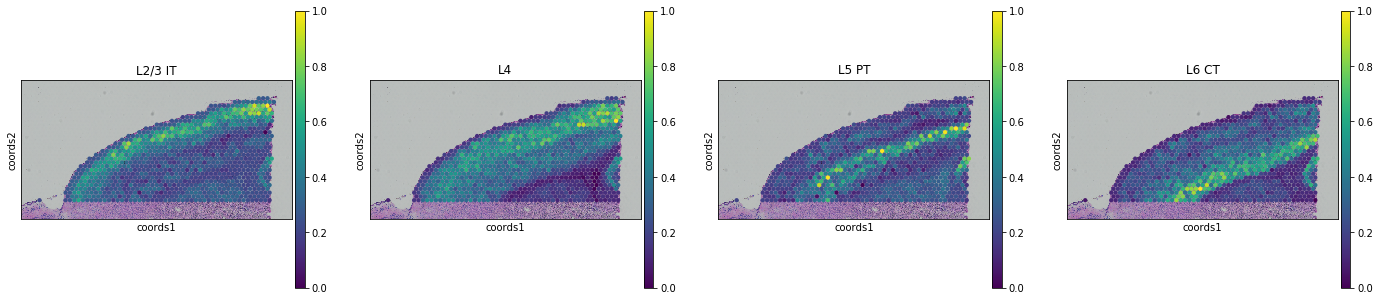

... storing 'feature_types' as categorical
... storing 'genome' as categorical


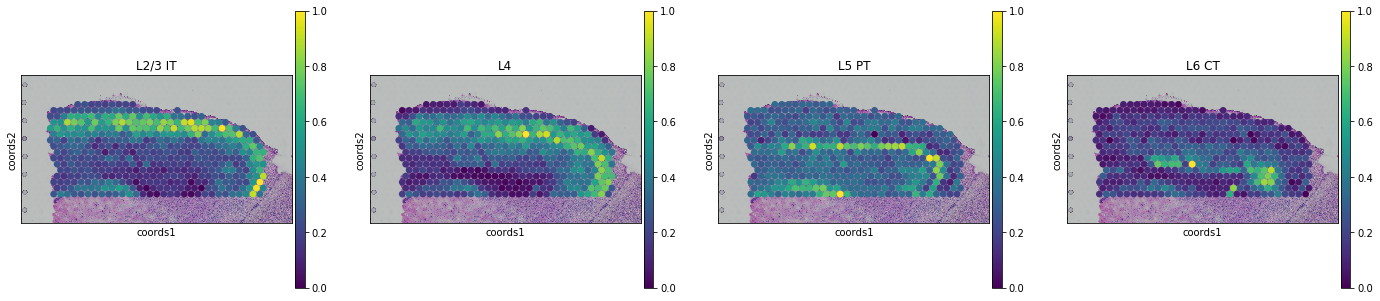

In [106]:
sc.pl.spatial(adata_anterior_subset_transfer, img_key = "hires", color=["L2/3 IT","L4","L5 PT","L6 CT"], size=1.5)
sc.pl.spatial(adata_posterior_subset_transfer, img_key = "hires", color=["L2/3 IT","L4","L5 PT","L6 CT"], size=1.5)

Interestingly, it seems that this approach worked, since sequential layers of cortical neurons could be correctly identified, both in the anterior and posterior sagittal slide.

We can go ahead an visualize astrocytes and oligodendrocytes as well.

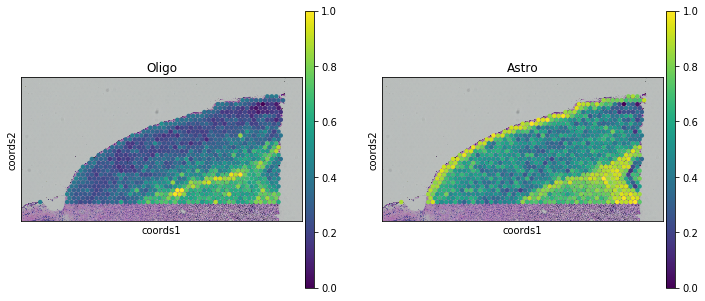

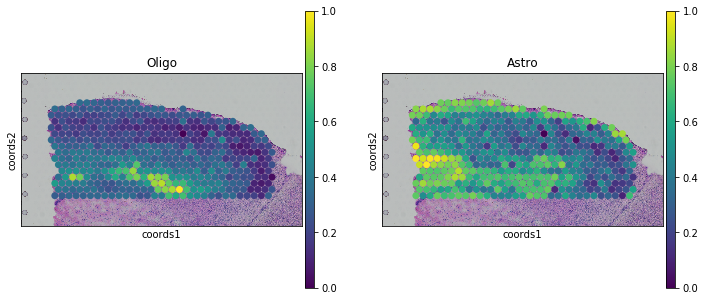

In [107]:
sc.pl.spatial(adata_anterior_subset_transfer, img_key = "hires", color=["Oligo","Astro"], size=1.5)
sc.pl.spatial(adata_posterior_subset_transfer, img_key = "hires", color=["Oligo","Astro"], size=1.5)

In this tutorial, we showed how to work with multiple slices in Scanpy, and perform label transfers between an annotated scRNA-seq dataset and an unannotated Visium dataset. We showed that such approach, that leverages the data integration performances of Scanorama, is useful and provide a straightforward tool for exploratory analysis.

However, for the label transfer task, we advise analysts to explore more principled approaches, based on cell-type deconvolution, that are likely to provide with more accurate and interpretable answers, see recent approaches such as:  
* **Stereoscope** [paper](https://www.biorxiv.org/content/10.1101/2019.12.13.874495v1) - [code](https://github.com/almaan/stereoscope)
* **AutogeneS** [paper](https://www.biorxiv.org/content/10.1101/2020.02.21.940650v1) - [code](https://github.com/theislab/AutoGeneS)
* **MuSiC** [paper](https://www.nature.com/articles/s41467-018-08023-x) - [code](https://github.com/xuranw/MuSiC)
* **CIBERSORT-X** [paper](https://www.nature.com/articles/s41587-019-0114-2) - [webtool](https://cibersortx.stanford.edu/)
* **Deconv-seq** [code](https://github.com/rosedu1/deconvSeq)